#Bert eval

In [1]:
import pandas as pd

translated_df = pd.read_csv('/content/random_translated_mental_health_chat_dataset.csv')


In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U loralib
!pip install -q -U einops
!pip install hugchat==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarro

In [5]:
import json
import os
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers

from pprint import pprint
from tqdm import tqdm
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your termin

In [8]:
PEFT_MODEL = "thailevann/ura-llama-7b-mental-health_1"

config = PeftConfig.from_pretrained(PEFT_MODEL)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
if not config.base_model_name_or_path:
    config.base_model_name_or_path = "ura-hcmut/ura-llama-7b"

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/160M [00:00<?, ?B/s]

In [9]:

generation_config = model.generation_config
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = model.config.pad_token_id
generation_config.eos_token_id = model.config.eos_token_id
generation_config.no_repeat_ngram_size=3

generation_config.do_sample = True       # Sử dụng sampling

In [10]:
import re

def is_complete(text):
    # Kiểm tra xem văn bản có kết thúc bằng dấu chấm, dấu chấm than, hoặc ký tự xuống dòng không
    return re.search(r'(\.|!|\?)$', text) is not None

def get_complete_text(text):
    # Cắt văn bản dư thừa sau dấu chấm, dấu chấm than, hoặc ký tự xuống dòng cuối cùng
    match = re.search(r'(\.|!|\?)\s*$', text)
    if match:
        end_pos = match.end()
        return text[:end_pos]
    return text

def process_response(response):
    # Kiểm tra và cắt văn bản sinh ra
    if not is_complete(response):
        response = get_complete_text(response)
    return response


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

question = "Tôi cảm thấy lo lắng và căng thẳng mỗi khi phải đối mặt với những tình huống không lường trước được trong công việc. Tôi không chắc làm thế nào để quản lý cảm xúc của mình và giữ bình tĩnh trong những lúc như vậy. Bạn có thể giúp tôi tìm ra cách xử lý hiệu quả hơn không?"
prompt = f"""[INST] <>
Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.
<>

Hãy trả lời câu hỏi sau.
Câu hỏi: {question}  [/INST]
Trả lời:
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config
    )

complete = process_response(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(complete)

[INST] <>
Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.
<>

Hãy trả lời câu hỏi sau.
Câu hỏi: Tôi cảm thấy lo lắng và căng thẳng mỗi khi phải đối mặt với những tình huống không lường trước được trong công việc. Tôi không chắc làm thế nào để quản lý cảm xúc của mình và giữ bình tĩnh trong những lúc như vậy. Bạn có thể giúp tôi tìm ra cách xử lý hiệu quả hơn không?  [/INST]
Trả lời: Cảm giác lo lương về tì nhân và cảnh báo khó khăn trong tì mọi thứ đều là nhà củ cây. Để giữ thái Đây là mối quan tâmerởi về mộc nên nếu bạn muốn giữ đây thì bạ n phản động vớ làm gì đó đã khả quan và điều chỉnh lại nó. Bổ sung các nguyên tắc và thói quen mới Ở đoạn này bạ bạ chằng chứng khoái cừ và tăng cườm vì khủng hoảng tâmp thầm. Có nhìn nhẹ vào chính mìm bạ và nhất là khâm phục vì bản thân mì ẩn chứa nhạy cả. Bộc bạch về cả chín củ mì nàng. Tìm cách đại diện cho mì mì bẻ tay nhớt, khốn khe. Tư vất và bỡng bῗ về ch

In [13]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00


In [3]:
pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00


In [4]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3219dd9d64f8f7252d86b0b26d6efd04415a15b1ada5589aef608b9db3968b7f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [14]:
%%time
from bert_score import score as bert_score
import sacrebleu
from rouge_score import rouge_scorer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []
for i, row in tqdm(translated_df.iterrows()):
    question_text_vi = row['questionText']
    answer_text_vi = row['answerText']
    prompt = f"""[INST] <>
    Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.
    <>

    Hãy trả lời câu hỏi sau.
    Câu hỏi:  {question_text_vi}  [/INST]
    Trả lời:
    """.strip()


    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    complete_response = process_response(response)
    complete_response =  complete_response.split("[/INST]")[-1].split("Trả lời")[-1]
    # Tính BERTScore
    P, R, F1 = bert_score([complete_response], [answer_text_vi], lang="vi", rescale_with_baseline=True)

    # Tính BLEU score
    bleu = sacrebleu.corpus_bleu([complete_response], [[answer_text_vi]]).score

    # Tính ROUGE score
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge_scorer_inst.score(complete_response, answer_text_vi)

    # Lưu kết quả
    result = {
        'questionText': question_text_vi,
        'predictedAnswer': complete_response,
        'actualAnswer': answer_text_vi,
        'bert_score': {
            'precision': P.item(),
            'recall': R.item(),
            'f1': F1.item()
        },
        'bleu_score': bleu,
        'rouge_score': {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure
        }
    }
    results.append(result)

# Lưu kết quả vào file JSON
with open('bert_score_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

CPU times: user 51min 12s, sys: 29.5 s, total: 51min 42s
Wall time: 52min 20s


Precision trung bình: 0.550491164624691
Recall trung bình: 0.6327045738697052
F1 trung bình: 0.5879850417375565
BLEU trung bình: 0.3927546738194501
ROUGE-1 trung bình: 0.42124846529891197
ROUGE-2 trung bình: 0.19443866913476665


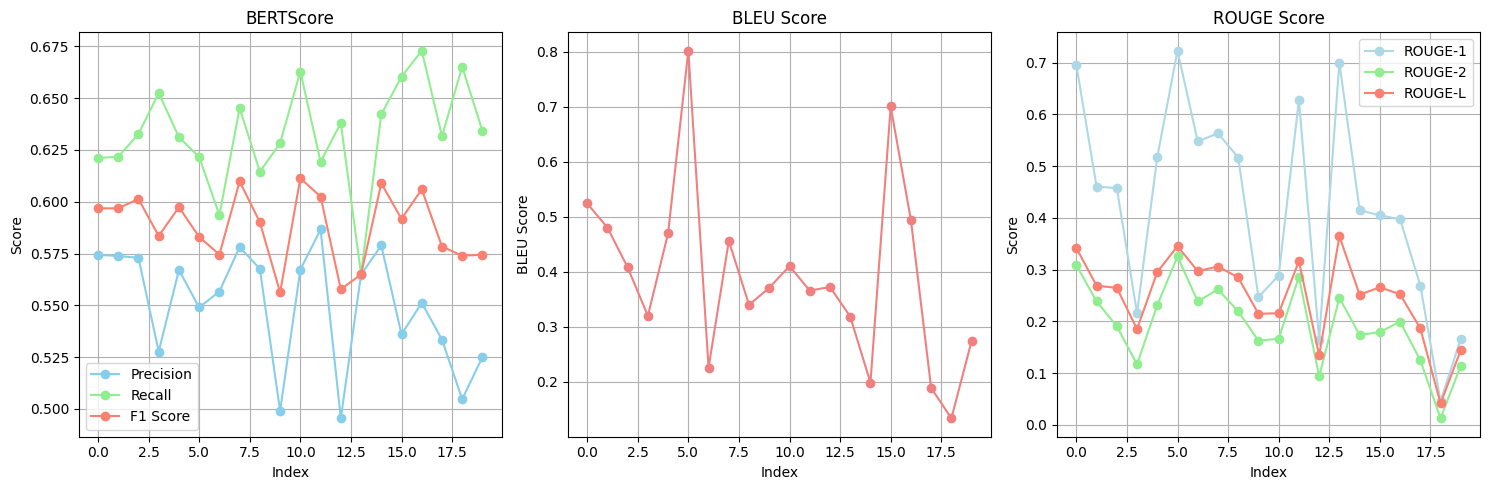

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np
# Đọc dữ liệu từ tệp JSON
with open('bert_score_results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo các danh sách để lưu trữ các giá trị cho từng chỉ số
precision = []
recall = []
f1 = []
bleu_scores = []
rouge1 = []
rouge2 = []
rougeL = []


# Duyệt qua từng đối tượng trong danh sách
for item in data:
    bert_scores = item["bert_score"]
    precision.append(bert_scores["precision"])
    recall.append(bert_scores["recall"])
    f1.append(bert_scores["f1"])

    bleu_scores.append(item["bleu_score"])

    rouge_scores = item["rouge_score"]
    rouge1.append(rouge_scores["rouge1"])
    rouge2.append(rouge_scores["rouge2"])
    rougeL.append(rouge_scores["rougeL"])
# Tính giá trị trung bình cho mỗi danh sách
precision_mean = np.mean(precision)
recall_mean= np.mean(recall)
f1_mean = np.mean(f1)
bleu_mean = np.mean(bleu_scores)
rouge1_mean = np.mean(rouge1)
rouge2_mean = np.mean(rouge2)
rougeL_mean = np.mean(rougeL)
# Kết quả của mô hình ura (giả sử bạn đã tính toán các giá trị này)
ura_scores = {
    "Precision": precision_mean,
    "Recall": recall_mean,
    "F1": f1_mean,
    "BLEU": bleu_mean,
    "ROUGE-1": rouge1_mean,
    "ROUGE-2": rouge2_mean,
    "ROUGE-L": rougeL_mean
}
# In kết quả
print(f"Precision trung bình: {precision_mean}")
print(f"Recall trung bình: {recall_mean}")
print(f"F1 trung bình: {f1_mean}")
print(f"BLEU trung bình: {bleu_mean}")
print(f"ROUGE-1 trung bình: {rouge1_mean}")
print(f"ROUGE-2 trung bình: {rouge2_mean}")
# Vẽ sơ đồ đường cho BERTScore
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(precision)), precision, marker='o', label='Precision', color='skyblue')
plt.plot(range(len(recall)), recall, marker='o', label='Recall', color='lightgreen')
plt.plot(range(len(f1)), f1, marker='o', label='F1 Score', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('BERTScore')
plt.legend()
plt.grid(True)

# Vẽ sơ đồ đường cho BLEU Score
plt.subplot(1, 3, 2)
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', color='lightcoral')
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')
plt.grid(True)

# Vẽ sơ đồ đường cho ROUGE Score
plt.subplot(1, 3, 3)
plt.plot(range(len(rouge1)), rouge1, marker='o', label='ROUGE-1', color='lightblue')
plt.plot(range(len(rouge2)), rouge2, marker='o', label='ROUGE-2', color='lightgreen')
plt.plot(range(len(rougeL)), rougeL, marker='o', label='ROUGE-L', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('ROUGE Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('score_trends.png')
plt.show()



Precision trung bình: 0.6374900490045547
Recall trung bình: 0.6883982330560684
F1 trung bình: 0.6611325591802597
BLEU trung bình: 1.5635242957210513
ROUGE-1 trung bình: 0.21260050352702659
ROUGE-2 trung bình: 0.13863112937558478


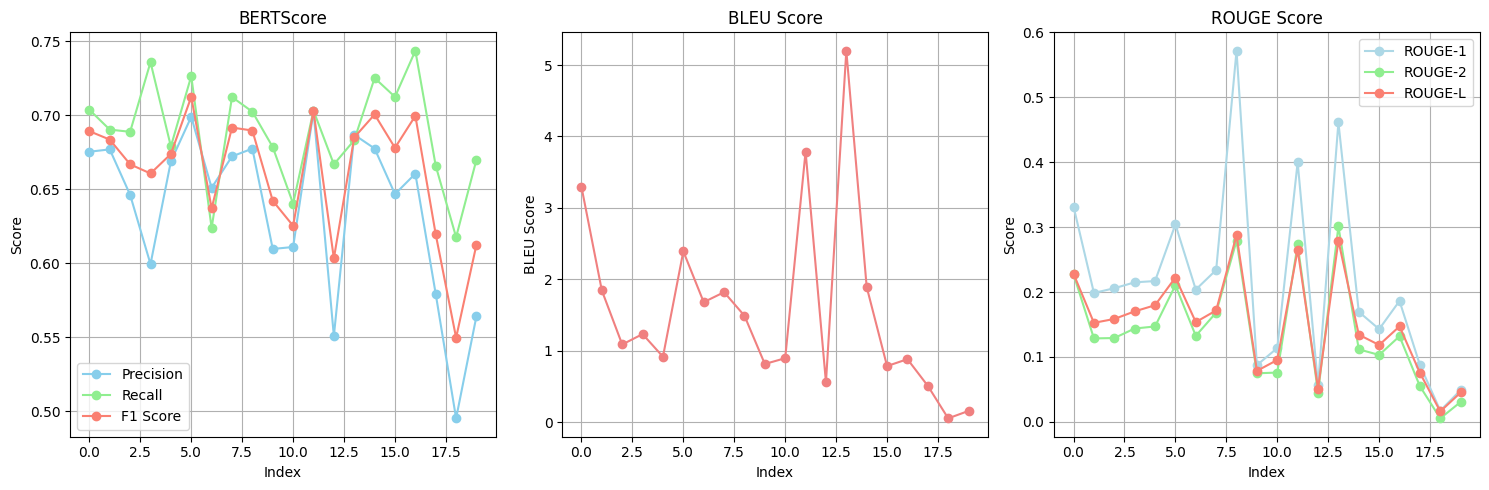

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np
# Đọc dữ liệu từ tệp JSON
with open('/content/vinallama-score.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo các danh sách để lưu trữ các giá trị cho từng chỉ số
precision = []
recall = []
f1 = []
bleu_scores = []
rouge1 = []
rouge2 = []
rougeL = []


# Duyệt qua từng đối tượng trong danh sách
for item in data:
    bert_scores = item["bert_score"]
    precision.append(bert_scores["precision"])
    recall.append(bert_scores["recall"])
    f1.append(bert_scores["f1"])

    bleu_scores.append(item["bleu_score"])

    rouge_scores = item["rouge_score"]
    rouge1.append(rouge_scores["rouge1"])
    rouge2.append(rouge_scores["rouge2"])
    rougeL.append(rouge_scores["rougeL"])
# Tính giá trị trung bình cho mỗi danh sách
precision_mean = np.mean(precision)
recall_mean = np.mean(recall)
f1_mean = np.mean(f1)
bleu_mean = np.mean(bleu_scores)
rouge1_mean = np.mean(rouge1)
rouge2_mean = np.mean(rouge2)
rougeL_mean = np.mean(rougeL)

# In kết quả
print(f"Precision trung bình: {precision_mean}")
print(f"Recall trung bình: {recall_mean}")
print(f"F1 trung bình: {f1_mean}")
print(f"BLEU trung bình: {bleu_mean}")
print(f"ROUGE-1 trung bình: {rouge1_mean}")
print(f"ROUGE-2 trung bình: {rouge2_mean}")

vinallama_scores = {
    "Precision": precision_mean,
    "Recall": recall_mean,
    "F1": f1_mean,
    "BLEU": bleu_mean,
    "ROUGE-1": rouge1_mean,
    "ROUGE-2": rouge2_mean,
    "ROUGE-L": rougeL_mean
}

# Vẽ sơ đồ đường cho BERTScore
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(precision)), precision, marker='o', label='Precision', color='skyblue')
plt.plot(range(len(recall)), recall, marker='o', label='Recall', color='lightgreen')
plt.plot(range(len(f1)), f1, marker='o', label='F1 Score', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('BERTScore')
plt.legend()
plt.grid(True)

# Vẽ sơ đồ đường cho BLEU Score
plt.subplot(1, 3, 2)
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', color='lightcoral')
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')
plt.grid(True)

# Vẽ sơ đồ đường cho ROUGE Score
plt.subplot(1, 3, 3)
plt.plot(range(len(rouge1)), rouge1, marker='o', label='ROUGE-1', color='lightblue')
plt.plot(range(len(rouge2)), rouge2, marker='o', label='ROUGE-2', color='lightgreen')
plt.plot(range(len(rougeL)), rougeL, marker='o', label='ROUGE-L', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('ROUGE Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('score_trends.png')
plt.show()



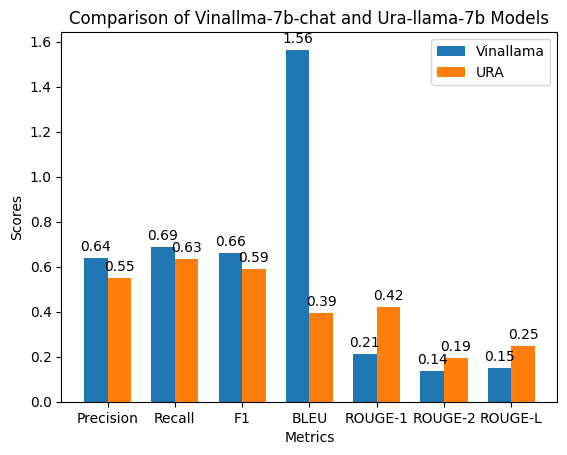

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Các chỉ số cần so sánh
metrics = list(vinallama_scores.keys())
vinallama_values = list(vinallama_scores.values())
ura_values = list(ura_scores.values())

# Thiết lập vị trí các thanh
x = np.arange(len(metrics))
width = 0.35  # Độ rộng của mỗi thanh

# Vẽ biểu đồ
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, vinallama_values, width, label='Vinallama')
bars2 = ax.bar(x + width/2, ura_values, width, label='URA')

# Thêm các chi tiết cho biểu đồ
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Vinallma-7b-chat and Ura-llama-7b Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên mỗi thanh
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Hiển thị biểu đồ
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Các chỉ số cần so sánh
metrics = list(vinallama_scores.keys())
vinallama_values = list(vinallama_scores.values())
ura_values = list(ura_scores.values())

# Thiết lập vị trí các thanh
x = np.arange(len(metrics))
width = 0.35  # Độ rộng của mỗi thanh

# Vẽ biểu đồ
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, vinallama_values, width, label='Vinallama')
bars2 = ax.bar(x + width/2, ura_values, width, label='URA')

# Thêm các chi tiết cho biểu đồ
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Vinallama and URA Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên mỗi thanh
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Hiển thị biểu đồ
plt.show()
